In [1]:
import pandas as pd
import numpy as np
from Plotter.aggregation import (
    RowFigureConcatenationReport,
    ColumnFigureConcatenationReport,
)
from Plotter.text import TitleReport

from Plotter.line import *
from Plotter.bar import *
from Plotter.table import *
import datetime

import empyrical as ep

In [2]:
name = "Libra"
test = pd.read_pickle(f"New/{name}Test.pkl") 
validation = pd.read_pickle(f"New/{name}.pkl") 

In [3]:
tickers=[
      'ZF=F', 'ZT=F', 'ZB=F', "ZN=F",
      "ES=F", "YM=F", "NQ=F", "RTY=F",
      "GC=F", "SI=F", "ZC=F", "CL=F", "SB=F", "CT=F",
      "EUR=X", "JPY=X", "GBP=X", 'BRL=X', "MXN=X", "CAD=X"
  ]
ticker = "GBP=X"

In [4]:
# best = [20, 1, 4] # ESF
# best = [13, 23, 24] # YM
# best = [23] # NQ

# best = [15, 24, 3] # EUR
# best = [8, 18, 6, 13, 2, 19] # JPY
best = [12] # GBP

# best = [5, 2, 0, 4, 10, 8] # Gold

aux = {}
aux[f"{ticker}"] = validation[0][f"{ticker}"]
aux[f"{ticker}_Real"] = validation[0][f"{ticker}_Real"]
aux[f"{ticker}_Date"] = validation[0][f"{ticker}_Date"]
validation_output = pd.DataFrame(aux).set_index(f"{ticker}_Date")
validation_output[f"{ticker}"] = validation_output[f"{ticker}"]*0

aux = {}
aux[f"{ticker}"] = test[0][f"{ticker}"]
aux[f"{ticker}_Real"] = test[0][f"{ticker}_Real"]
aux[f"{ticker}_Date"] = test[0][f"{ticker}_Date"]
test_output = pd.DataFrame(aux).set_index(f"{ticker}_Date")
test_output[f"{ticker}"] = test_output[f"{ticker}"]*0


In [5]:
best = best[-1:]
for k in best:
    validation_output[f"{ticker}"] = validation_output[f"{ticker}"] + validation[k][f"{ticker}"]

validation_output[f'{ticker}'] = validation_output[f'{ticker}']/len(best)

for k in best:
    test_output[f"{ticker}"] = test_output[f"{ticker}"] + test[k][f"{ticker}"]

test_output[f'{ticker}'] = test_output[f'{ticker}']/len(best)

test_output = pd.concat([validation_output, test_output], axis=0)


In [6]:
test_output[f"{ticker}_Real"] = np.exp(test_output[f"{ticker}_Real"])-1
test_output[f"{ticker}"] = np.exp(test_output[f"{ticker}"])-1
win_rate_list = np.sign(test_output[f"{ticker}"]) == np.sign(test_output[f"{ticker}_Real"])
test_output["Returns"] = np.sign(test_output[f"{ticker}"]) * test_output[f"{ticker}_Real"]
test_output.index.rename('date', inplace=True)
test_output.index = pd.to_datetime(test_output.index)
signs = np.sign(test_output[f"{ticker}"])
test_output.rename(columns={f'{ticker}_Real':f'{ticker} Long Only', 'Returns': f"{ticker} Using TFT"}, inplace=True)
full_returns = test_output[[F'{ticker} Long Only', f"{ticker} Using TFT"]].melt(ignore_index=False, var_name='asset', value_name='Return').reset_index().groupby(['date', 'asset']).sum()['Return']

In [7]:
signs.value_counts()

 1.0    831
-1.0    810
Name: GBP=X, dtype: int64

In [8]:
win_rate_list.value_counts()

True     842
False    799
dtype: int64

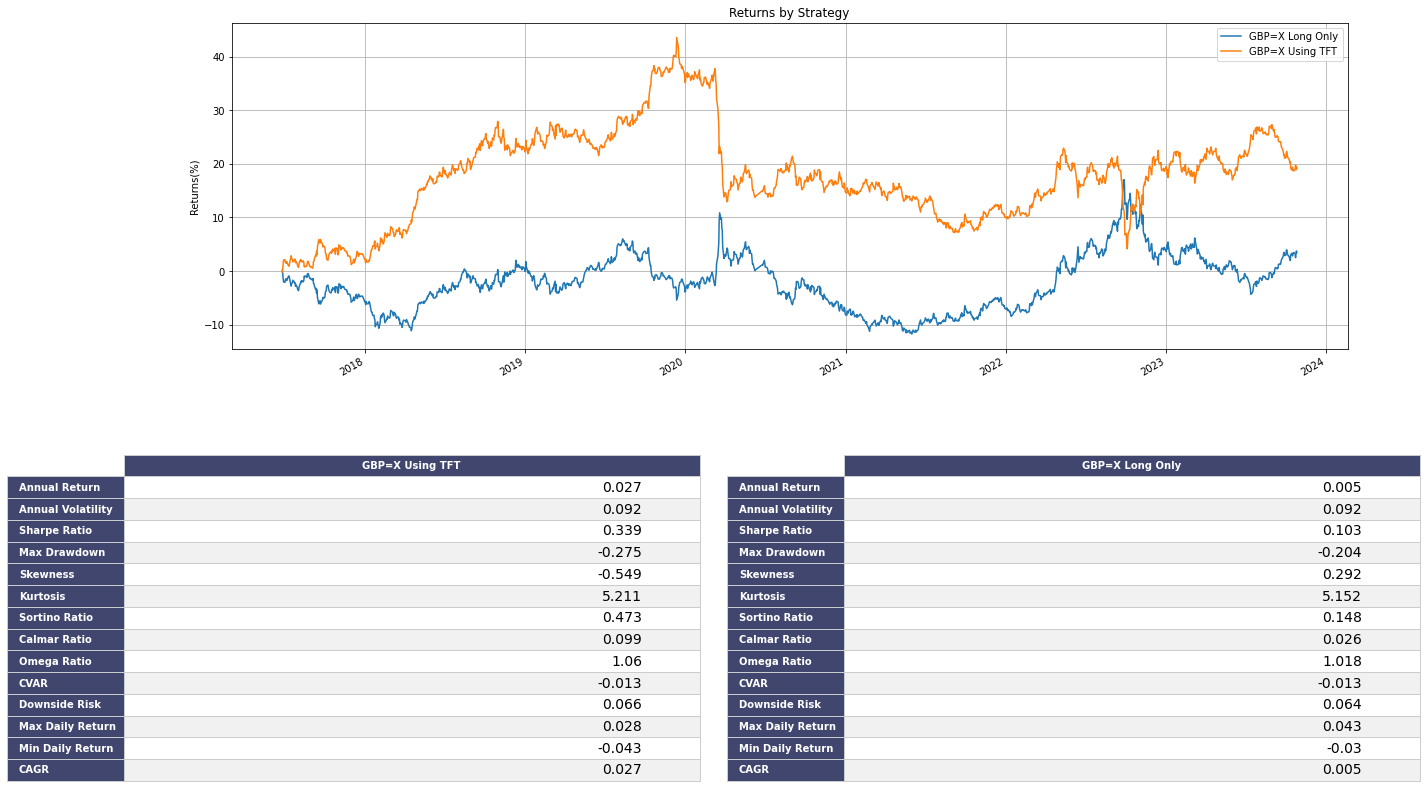

In [9]:
line_returns = CumulativeReturnsWithBenchmarks.from_returns(full_returns, title='Returns by Strategy', ylabel='Returns(%)', figsize=(20, 6))
r1 = ReturnMetricsTable.from_returns(test_output[f"{ticker} Using TFT"], font_size=10, num_font_size=14, vertical=True, figsize=(3, 6), use_index=True, name=f"{ticker} Using TFT")
r2 = ReturnMetricsTable.from_returns(test_output[f'{ticker} Long Only'], font_size=10, num_font_size=14, vertical=True, figsize=(3, 6), use_index=True, name=f'{ticker} Long Only')
row2 = ColumnFigureConcatenationReport.from_report_list([r1, r2], padding=0.1)
RowFigureConcatenationReport.from_report_list([line_returns, row2]).plot()